# DIABETES EDA & FEATURE ENGINEERING

## Importing Modules & Dataset

In [302]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,roc_auc_score
from sklearn.model_selection import GridSearchCV, cross_validate
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
import warnings
warnings.simplefilter(action="ignore")

pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_rows', 20)
pd.set_option('display.float_format', lambda x: '%.3f' % x)


In [303]:
def load():
    data = pd.read_csv("diabetes.csv")
    return data

In [304]:
df = load()

In [305]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
    """

    Veri setindeki kategorik, numerik ve kategorik fakat kardinal değişkenlerin isimlerini verir.
    Not: Kategorik değişkenlerin içerisine numerik görünümlü kategorik değişkenler de dahildir.

    Parameters
    ------
        dataframe: dataframe
                Değişken isimleri alınmak istenilen dataframe
        cat_th: int, optional
                numerik fakat kategorik olan değişkenler için sınıf eşik değeri
        car_th: int, optinal
                kategorik fakat kardinal değişkenler için sınıf eşik değeri

    Returns
    ------
        cat_cols: list
                Kategorik değişken listesi
        num_cols: list
                Numerik değişken listesi
        cat_but_car: list
                Kategorik görünümlü kardinal değişken listesi

    Examples
    ------
        import seaborn as sns
        df = sns.load_dataset("iris")
        print(grab_col_names(df))


    Notes
    ------
        cat_cols + num_cols + cat_but_car = toplam değişken sayısı
        num_but_cat cat_cols'un içerisinde.
        Return olan 3 liste toplamı toplam değişken sayısına eşittir: cat_cols + num_cols + cat_but_car = değişken sayısı

    """

    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car

In [306]:
def cat_summary(dataframe, col_name, plot=False):
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))
    print("##########################################")
    if plot:
        sns.countplot(x=dataframe[col_name], data=dataframe)
        plt.show()

In [307]:
def num_summary(dataframe, numerical_col, plot=False):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    print(dataframe[numerical_col].describe(quantiles).T)

    if plot:
        dataframe[numerical_col].hist(bins=20)
        plt.xlabel(numerical_col)
        plt.title(numerical_col)
        plt.show(block=True)

In [308]:
def outlier_thresholds(dataframe, col_name, q1=0.25, q3=0.75):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

In [309]:
def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

In [310]:
def grab_outliers(dataframe, col_name, index=False):
    low, up = outlier_thresholds(dataframe, col_name)

    if dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].shape[0] > 10:
        print(dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].head())
        print(dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].shape)
    else:
        print(dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))])

    if index:
        outlier_index = dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].index
        return outlier_index


In [311]:
def remove_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    df_without_outliers = dataframe[~((dataframe[col_name] < low_limit) | (dataframe[col_name] > up_limit))]
    return df_without_outliers

In [312]:
#Replacing may be more useful if removing entire row is not desired
def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

In [313]:
def missing_values_table(dataframe, na_name=False):
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]

    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
    ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])
    print(missing_df, end="\n")

    if na_name:
        return na_columns


In [314]:
def label_encoder(dataframe, binary_col):
    labelencoder = LabelEncoder()
    dataframe[binary_col] = labelencoder.fit_transform(dataframe[binary_col])
    return dataframe

In [315]:
def rare_analyser(dataframe, target, cat_cols):
    for col in cat_cols:
        print(col, ":", len(dataframe[col].value_counts()))
        print(pd.DataFrame({"COUNT": dataframe[col].value_counts(),
                            "RATIO": dataframe[col].value_counts() / len(dataframe),
                            "TARGET_MEAN": dataframe.groupby(col)[target].mean()}), end="\n\n\n")

In [316]:
def rare_encoder(dataframe, rare_perc):
    temp_df = dataframe.copy()

    rare_columns = [col for col in temp_df.columns if temp_df[col].dtypes == 'O'
                    and (temp_df[col].value_counts() / len(temp_df) < rare_perc).any(axis=None)]

    for var in rare_columns:
        tmp = temp_df[var].value_counts() / len(temp_df)
        rare_labels = tmp[tmp < rare_perc].index
        temp_df[var] = np.where(temp_df[var].isin(rare_labels), 'Rare', temp_df[var])

    return temp_df

In [317]:
def one_hot_encoder(dataframe, categorical_cols, drop_first=True):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe

In [318]:
def check(df, head = 5):
    print("**********************************HEAD**********************************")
    print(df.head(head))
    print("**********************************TAIL**********************************")
    print(df.tail(head))
    print("**********************************TYPES**********************************")
    print(df.dtypes)
    print("**********************************SHAPE**********************************")
    print(df.shape)
    print("**********************************NA**********************************")
    print(df.isnull().sum())
    print("**********************************QUANTILES**********************************")
    print(df.describe([0, 0.05, 0.5, 0.95]))

In [319]:
def high_correlated_cols(df, plot=False, corr_th = 0.9):
    corr  = df.corr()
    corr_matrix = corr.abs()
    upper_traingle_matrix = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k = 1 ).astype(np.bool))
    drop_list = [col for col in upper_traingle_matrix.columns if any(upper_traingle_matrix[col] > corr_th)]
    if plot:
        import seaborn as sns
        import matplotlib.pyplot as plt
        sns.set(rc={"figure.figsize" : (15,15)})
        sns.heatmap(corr, cmap="RdBu")
        plt.show()
        
    return drop_list

## Exploratory Data Analysis

In [320]:
#Checking The Data
check(df)

**********************************HEAD**********************************
   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin    BMI  \
0            6      148             72             35        0 33.600   
1            1       85             66             29        0 26.600   
2            8      183             64              0        0 23.300   
3            1       89             66             23       94 28.100   
4            0      137             40             35      168 43.100   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  
**********************************TAIL**********************************
     Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin    BMI  \
763           10      101             76             48      180 32.900   
7

In [321]:
#Catching The Columns by Types
cats,nums,cards = grab_col_names(df)

Observations: 768
Variables: 9
cat_cols: 1
num_cols: 8
cat_but_car: 0
num_but_cat: 1


In [322]:
nums

['Pregnancies',
 'Glucose',
 'BloodPressure',
 'SkinThickness',
 'Insulin',
 'BMI',
 'DiabetesPedigreeFunction',
 'Age']

In [323]:
cats

['Outcome']

   Outcome  Ratio
0      500 65.104
1      268 34.896
##########################################


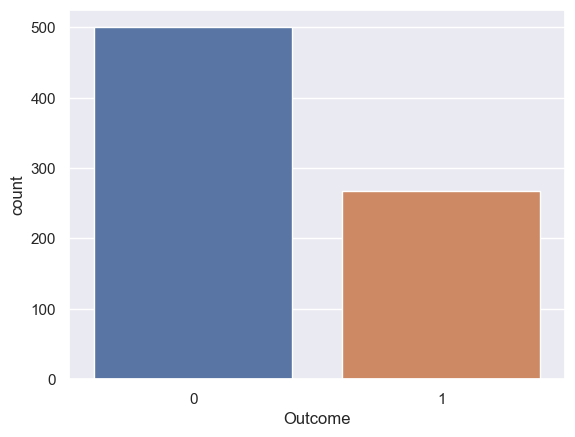

In [324]:
#Summary of Categoricals
for col in cats:
    cat_summary(df, col, True )

count   768.000
mean      3.845
std       3.370
min       0.000
5%        0.000
10%       0.000
20%       1.000
30%       1.000
40%       2.000
50%       3.000
60%       4.000
70%       5.000
80%       7.000
90%       9.000
95%      10.000
99%      13.000
max      17.000
Name: Pregnancies, dtype: float64


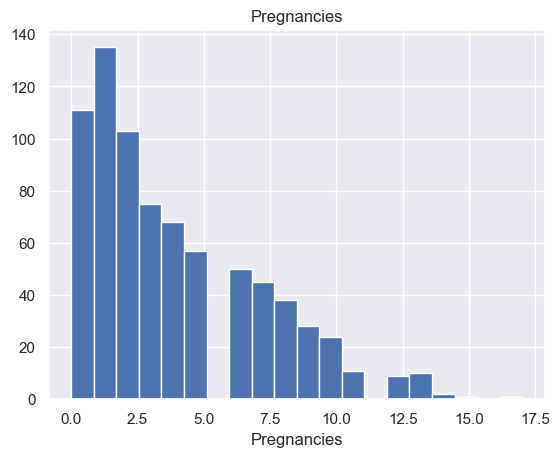

count   768.000
mean    120.895
std      31.973
min       0.000
5%       79.000
10%      85.000
20%      95.000
30%     102.000
40%     109.000
50%     117.000
60%     125.000
70%     134.000
80%     147.000
90%     167.000
95%     181.000
99%     196.000
max     199.000
Name: Glucose, dtype: float64


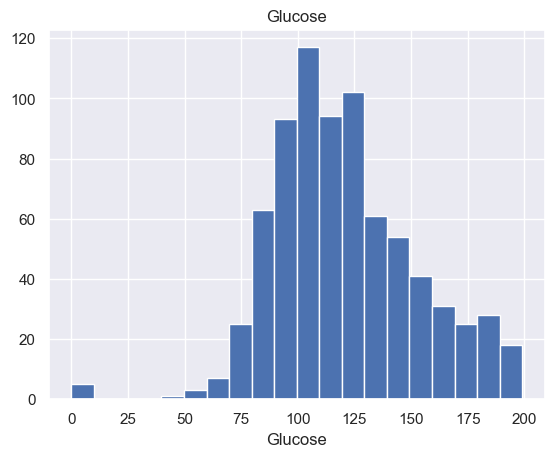

count   768.000
mean     69.105
std      19.356
min       0.000
5%       38.700
10%      54.000
20%      60.000
30%      64.000
40%      68.000
50%      72.000
60%      74.000
70%      78.000
80%      82.000
90%      88.000
95%      90.000
99%     106.000
max     122.000
Name: BloodPressure, dtype: float64


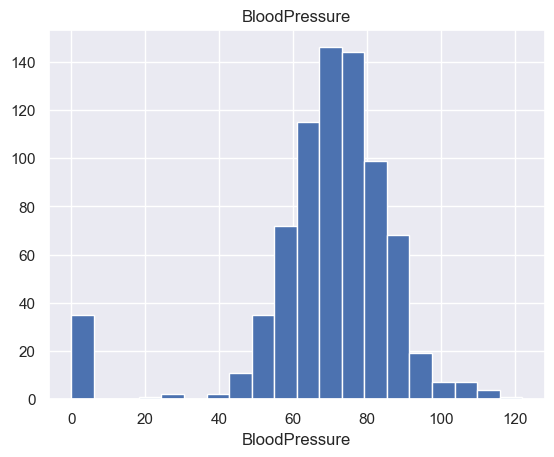

count   768.000
mean     20.536
std      15.952
min       0.000
5%        0.000
10%       0.000
20%       0.000
30%       8.200
40%      18.000
50%      23.000
60%      27.000
70%      31.000
80%      35.000
90%      40.000
95%      44.000
99%      51.330
max      99.000
Name: SkinThickness, dtype: float64


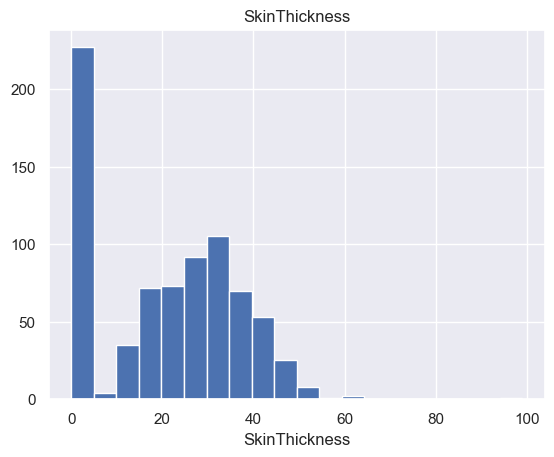

count   768.000
mean     79.799
std     115.244
min       0.000
5%        0.000
10%       0.000
20%       0.000
30%       0.000
40%       0.000
50%      30.500
60%      72.200
70%     106.000
80%     150.000
90%     210.000
95%     293.000
99%     519.900
max     846.000
Name: Insulin, dtype: float64


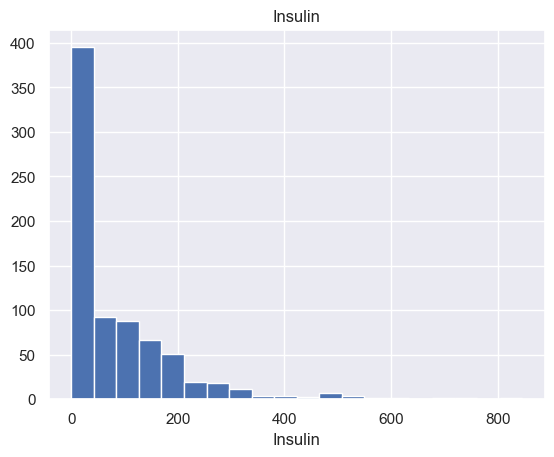

count   768.000
mean     31.993
std       7.884
min       0.000
5%       21.800
10%      23.600
20%      25.900
30%      28.200
40%      30.100
50%      32.000
60%      33.700
70%      35.490
80%      37.800
90%      41.500
95%      44.395
99%      50.759
max      67.100
Name: BMI, dtype: float64


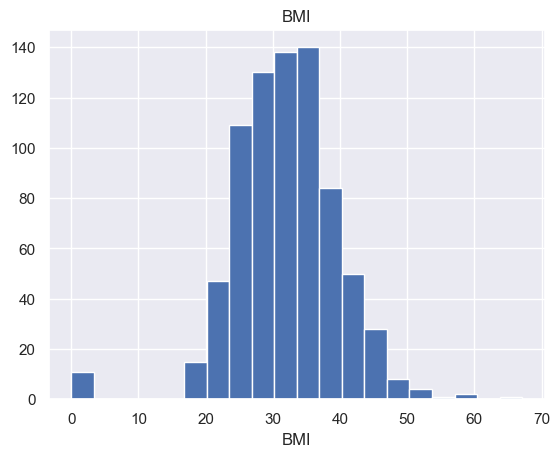

count   768.000
mean      0.472
std       0.331
min       0.078
5%        0.140
10%       0.165
20%       0.219
30%       0.259
40%       0.303
50%       0.372
60%       0.454
70%       0.564
80%       0.687
90%       0.879
95%       1.133
99%       1.698
max       2.420
Name: DiabetesPedigreeFunction, dtype: float64


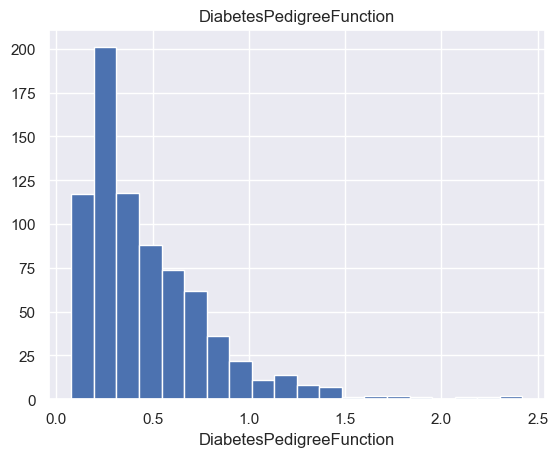

count   768.000
mean     33.241
std      11.760
min      21.000
5%       21.000
10%      22.000
20%      23.000
30%      25.000
40%      27.000
50%      29.000
60%      33.000
70%      38.000
80%      42.600
90%      51.000
95%      58.000
99%      67.000
max      81.000
Name: Age, dtype: float64


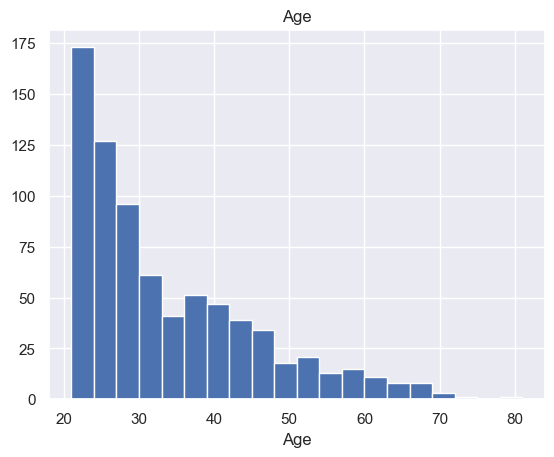

In [325]:
for col in nums:
    num_summary(df, col, True)

In [326]:
df.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')

In [327]:
#Target Feature Analysis
for col in df.drop("Outcome", axis=1).columns:
    display(df.groupby(col)["Outcome"].apply(lambda x : x.value_counts(normalize=True)))


Pregnancies   
0            0   0.658
             1   0.342
1            0   0.785
             1   0.215
2            0   0.816
                  ... 
13           0   0.500
             1   0.500
14           1   1.000
15           1   1.000
17           1   1.000
Name: Outcome, Length: 31, dtype: float64

Glucose   
0        0   0.600
         1   0.400
44       0   1.000
56       0   1.000
57       0   1.000
              ... 
196      1   1.000
197      1   0.750
         0   0.250
198      1   1.000
199      1   1.000
Name: Outcome, Length: 215, dtype: float64

BloodPressure   
0              0   0.543
               1   0.457
24             0   1.000
30             0   0.500
               1   0.500
                    ... 
108            0   0.500
110            1   0.667
               0   0.333
114            1   1.000
122            0   1.000
Name: Outcome, Length: 82, dtype: float64

SkinThickness   
0              0   0.612
               1   0.388
7              1   0.500
               0   0.500
8              0   1.000
                    ... 
54             0   1.000
56             1   1.000
60             0   1.000
63             1   1.000
99             1   1.000
Name: Outcome, Length: 89, dtype: float64

Insulin   
0        0   0.631
         1   0.369
14       1   1.000
15       0   1.000
16       0   1.000
              ... 
579      1   1.000
600      1   1.000
680      0   1.000
744      0   1.000
846      1   1.000
Name: Outcome, Length: 230, dtype: float64

BMI      
0.000   0   0.818
        1   0.182
18.200  0   1.000
18.400  0   1.000
19.100  0   1.000
             ... 
53.200  1   1.000
55.000  1   1.000
57.300  0   1.000
59.400  1   1.000
67.100  1   1.000
Name: Outcome, Length: 358, dtype: float64

DiabetesPedigreeFunction   
0.078                     0   1.000
0.084                     0   1.000
0.085                     0   1.000
0.088                     0   0.500
                          1   0.500
                               ... 
1.893                     1   1.000
2.137                     1   1.000
2.288                     1   1.000
2.329                     0   1.000
2.420                     1   1.000
Name: Outcome, Length: 603, dtype: float64

Age   
21   0   0.921
     1   0.079
22   0   0.847
     1   0.153
23   0   0.816
          ... 
68   0   1.000
69   0   1.000
70   1   1.000
72   0   1.000
81   0   1.000
Name: Outcome, Length: 96, dtype: float64

In [328]:
#Outliers Analysis
for col in df.columns:
    print(f"{col} : {check_outlier(df, col_name=col)}" )

Pregnancies : True
Glucose : True
BloodPressure : True
SkinThickness : True
Insulin : True
BMI : True
DiabetesPedigreeFunction : True
Age : True
Outcome : False


In [329]:
#Missing Values Analysis
missing_values_table(df)

Empty DataFrame
Columns: [n_miss, ratio]
Index: []


In [330]:
zero_columns = [col for col in df.columns if df[col].min() == 0 and col not in ["Pregnancies", "Outcome"]]
zero_columns

['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

In [331]:
#Replacing zeros with nan
for col in zero_columns:
    df[col] = np.where(df[col] == 0, np.nan, df[col])

In [332]:
missing_values_table(df, na_name=True)

               n_miss  ratio
Insulin           374 48.700
SkinThickness     227 29.560
BloodPressure      35  4.560
BMI                11  1.430
Glucose             5  0.650


['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

## Feature Engineering

### Handling The Missing Values

In [333]:
#Relationship between the target feature and missing values
def missing_vs_target(dataframe, target, na_columns):
    temp_df = dataframe.copy()
    for col in na_columns:
        temp_df[col + '_NA_FLAG'] = np.where(temp_df[col].isnull(), 1, 0)
    na_flags = temp_df.loc[:, temp_df.columns.str.contains("_NA_")].columns
    for col in na_flags:
        print(pd.DataFrame({"TARGET_MEAN": temp_df.groupby(col)[target].mean(),
                            "Count": temp_df.groupby(col)[target].count()}), end="\n\n\n")

In [334]:
missing_vs_target(df, "Outcome", zero_columns)

                 TARGET_MEAN  Count
Glucose_NA_FLAG                    
0                      0.349    763
1                      0.400      5


                       TARGET_MEAN  Count
BloodPressure_NA_FLAG                    
0                            0.344    733
1                            0.457     35


                       TARGET_MEAN  Count
SkinThickness_NA_FLAG                    
0                            0.333    541
1                            0.388    227


                 TARGET_MEAN  Count
Insulin_NA_FLAG                    
0                      0.330    394
1                      0.369    374


             TARGET_MEAN  Count
BMI_NA_FLAG                    
0                  0.351    757
1                  0.182     11




In [335]:
#Filling the missing values
for col in zero_columns:
    df.loc[df[col].isnull(), col] = df[col].median()

In [336]:
df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

### Handling The Outliers

In [337]:
#Replacing the outliers with thresholds
for col in df.columns:
    print(col, check_outlier(df, col))
    if check_outlier(df, col):
        replace_with_thresholds(df, col)

Pregnancies True
Glucose False
BloodPressure True
SkinThickness True
Insulin True
BMI True
DiabetesPedigreeFunction True
Age True
Outcome False


In [338]:
for col in df.columns:
    print(col, check_outlier(df, col))

Pregnancies False
Glucose False
BloodPressure False
SkinThickness False
Insulin False
BMI False
DiabetesPedigreeFunction False
Age False
Outcome False


### Feature Extraction

In [339]:
df.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')

In [340]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.000,3.837,3.344,0.000,1.000,3.000,6.000,13.500
Glucose,768.000,121.656,30.438,44.000,99.750,117.000,140.250,199.000
BloodPressure,768.000,72.358,11.697,40.000,64.000,72.000,80.000,104.000
SkinThickness,768.000,28.867,7.442,14.500,25.000,29.000,32.000,42.500
Insulin,768.000,124.691,7.914,112.875,121.500,125.000,127.250,135.875
BMI,768.000,32.393,6.667,18.200,27.500,32.300,36.600,50.250
DiabetesPedigreeFunction,768.000,0.459,0.286,0.078,0.244,0.372,0.626,1.200
Age,768.000,33.200,11.628,21.000,24.000,29.000,41.000,66.500
Outcome,768.000,0.349,0.477,0.000,0.000,0.000,1.000,1.000


In [341]:
#Age Feature 
bins = [df.Age.min()-1, 29, 50, df.Age.max()+1]
labels =  ["Young", "Adult", "Old" ]
df["Age_Cat"] = pd.cut(df.Age, bins, labels= labels)
df.head()


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,Age_Cat
0,6.000,148.000,72.000,35.000,125.000,33.600,0.627,50.000,1,Adult
1,1.000,85.000,66.000,29.000,125.000,26.600,0.351,31.000,0,Adult
2,8.000,183.000,64.000,29.000,125.000,23.300,0.672,32.000,1,Adult
3,1.000,89.000,66.000,23.000,112.875,28.100,0.167,21.000,0,Young
4,0.000,137.000,40.000,35.000,135.875,43.100,1.200,33.000,1,Adult


In [342]:
#BMI Feature
bins = [1, 18.5, 25, 30, df.BMI.max() + 1 ]
labels = ["Underweight", "Normal", "Overweight", "Obese"]
df["BMI_Cat"] = pd.cut(df.BMI, bins, labels = labels)
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,Age_Cat,BMI_Cat
0,6.000,148.000,72.000,35.000,125.000,33.600,0.627,50.000,1,Adult,Obese
1,1.000,85.000,66.000,29.000,125.000,26.600,0.351,31.000,0,Adult,Overweight
2,8.000,183.000,64.000,29.000,125.000,23.300,0.672,32.000,1,Adult,Normal
3,1.000,89.000,66.000,23.000,112.875,28.100,0.167,21.000,0,Young,Overweight
4,0.000,137.000,40.000,35.000,135.875,43.100,1.200,33.000,1,Adult,Obese


In [343]:
#Glucose Feature
df["Glucose_Cat"] = pd.cut(df.Glucose, bins= [0,140,200,300], labels= ["Normal", "Prediabetes", "Diabetes"])
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,Age_Cat,BMI_Cat,Glucose_Cat
0,6.000,148.000,72.000,35.000,125.000,33.600,0.627,50.000,1,Adult,Obese,Prediabetes
1,1.000,85.000,66.000,29.000,125.000,26.600,0.351,31.000,0,Adult,Overweight,Normal
2,8.000,183.000,64.000,29.000,125.000,23.300,0.672,32.000,1,Adult,Normal,Prediabetes
3,1.000,89.000,66.000,23.000,112.875,28.100,0.167,21.000,0,Young,Overweight,Normal
4,0.000,137.000,40.000,35.000,135.875,43.100,1.200,33.000,1,Adult,Obese,Normal


In [344]:
#Insulin Feature
def set_insulin(dataframe, col_name="Insulin"):
    if 16 <= dataframe[col_name] <= 166:
        return "Normal"
    else:
        return "Abnormal"
df["Insulin_Cat"] = df.apply(set_insulin, axis=1)

In [345]:
#New Cross Features
df["Glucose_Insulin"] = df["Glucose"] * df["Insulin"]
df["Glucose_Pregnancies"] = df["Glucose"] * (1+ df["Pregnancies"])


### Encoding

In [346]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 768
Variables: 15
cat_cols: 5
num_cols: 10
cat_but_car: 0
num_but_cat: 4


In [347]:
df.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome', 'Age_Cat',
       'BMI_Cat', 'Glucose_Cat', 'Insulin_Cat', 'Glucose_Insulin',
       'Glucose_Pregnancies'],
      dtype='object')

#### Label Encoding

In [348]:
binary_cols = [col for col in df.columns if df[col].dtypes == "category" and df[col].nunique() == 2]
binary_cols

['Glucose_Cat']

In [349]:
for col in binary_cols:
    df = label_encoder(df, col)

In [350]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,Age_Cat,BMI_Cat,Glucose_Cat,Insulin_Cat,Glucose_Insulin,Glucose_Pregnancies
0,6.000,148.000,72.000,35.000,125.000,33.600,0.627,50.000,1,Adult,Obese,1,Normal,18500.000,1036.000
1,1.000,85.000,66.000,29.000,125.000,26.600,0.351,31.000,0,Adult,Overweight,0,Normal,10625.000,170.000
2,8.000,183.000,64.000,29.000,125.000,23.300,0.672,32.000,1,Adult,Normal,1,Normal,22875.000,1647.000
3,1.000,89.000,66.000,23.000,112.875,28.100,0.167,21.000,0,Young,Overweight,0,Normal,10045.875,178.000
4,0.000,137.000,40.000,35.000,135.875,43.100,1.200,33.000,1,Adult,Obese,0,Normal,18614.875,137.000


#### One-Hot Encoding

In [351]:
cat_cols = [col for col in cat_cols if col not in binary_cols and col not in ["Outcome"]]
cat_cols

['Insulin_Cat', 'Age_Cat', 'BMI_Cat']

In [352]:
df = one_hot_encoder(df, cat_cols, drop_first=True)

In [353]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,Glucose_Cat,Glucose_Insulin,Glucose_Pregnancies,Age_Cat_Adult,Age_Cat_Old,BMI_Cat_Normal,BMI_Cat_Overweight,BMI_Cat_Obese
0,6.000,148.000,72.000,35.000,125.000,33.600,0.627,50.000,1,1,18500.000,1036.000,1,0,0,0,1
1,1.000,85.000,66.000,29.000,125.000,26.600,0.351,31.000,0,0,10625.000,170.000,1,0,0,1,0
2,8.000,183.000,64.000,29.000,125.000,23.300,0.672,32.000,1,1,22875.000,1647.000,1,0,1,0,0
3,1.000,89.000,66.000,23.000,112.875,28.100,0.167,21.000,0,0,10045.875,178.000,0,0,0,1,0
4,0.000,137.000,40.000,35.000,135.875,43.100,1.200,33.000,1,0,18614.875,137.000,1,0,0,0,1


#### Standardization

In [354]:
scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

In [355]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,Glucose_Cat,Glucose_Insulin,Glucose_Pregnancies,Age_Cat_Adult,Age_Cat_Old,BMI_Cat_Normal,BMI_Cat_Overweight,BMI_Cat_Obese
0,0.647,0.866,-0.031,0.825,0.039,0.181,0.589,1.446,1,1,0.750,0.926,1,0,0,0,1
1,-0.849,-1.205,-0.544,0.018,0.039,-0.869,-0.378,-0.189,0,0,-1.078,-0.919,1,0,0,1,0
2,1.246,2.017,-0.715,0.018,0.039,-1.365,0.747,-0.103,1,1,1.766,2.228,1,0,1,0,0
3,-0.849,-1.074,-0.544,-0.789,-1.494,-0.644,-1.023,-1.050,0,0,-1.212,-0.902,0,0,0,1,0
4,-1.148,0.504,-2.768,0.825,1.414,1.607,2.597,-0.017,1,0,0.777,-0.989,1,0,0,0,1


## Modelling

In [356]:
y = df.Outcome
X = df.drop("Outcome", axis = 1)

In [357]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=17)

In [358]:
rf_model = RandomForestClassifier(random_state=46).fit(X_train, y_train)

In [359]:
y_pred = rf_model.predict(X_test)

In [360]:
print(f"Accuracy: {round(accuracy_score(y_pred, y_test), 2)}")
print(f"Recall: {round(recall_score(y_pred,y_test),3)}")
print(f"Precision: {round(precision_score(y_pred,y_test), 2)}")
print(f"F1: {round(f1_score(y_pred,y_test), 2)}")
print(f"Auc: {round(roc_auc_score(y_pred,y_test), 2)}")

Accuracy: 0.79
Recall: 0.711
Precision: 0.67
F1: 0.69
Auc: 0.77


### Feature Importance

In [361]:
def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    print(feature_imp.sort_values("Value",ascending=False))
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                     ascending=False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig('importances.png')


    Value                   Feature
9   0.167           Glucose_Insulin
1   0.139                   Glucose
10  0.116       Glucose_Pregnancies
5   0.114                       BMI
7   0.095                       Age
6   0.094  DiabetesPedigreeFunction
2   0.057             BloodPressure
3   0.049             SkinThickness
0   0.044               Pregnancies
8   0.040               Glucose_Cat
4   0.031                   Insulin
11  0.020             Age_Cat_Adult
15  0.011             BMI_Cat_Obese
14  0.009        BMI_Cat_Overweight
13  0.007            BMI_Cat_Normal
12  0.006               Age_Cat_Old


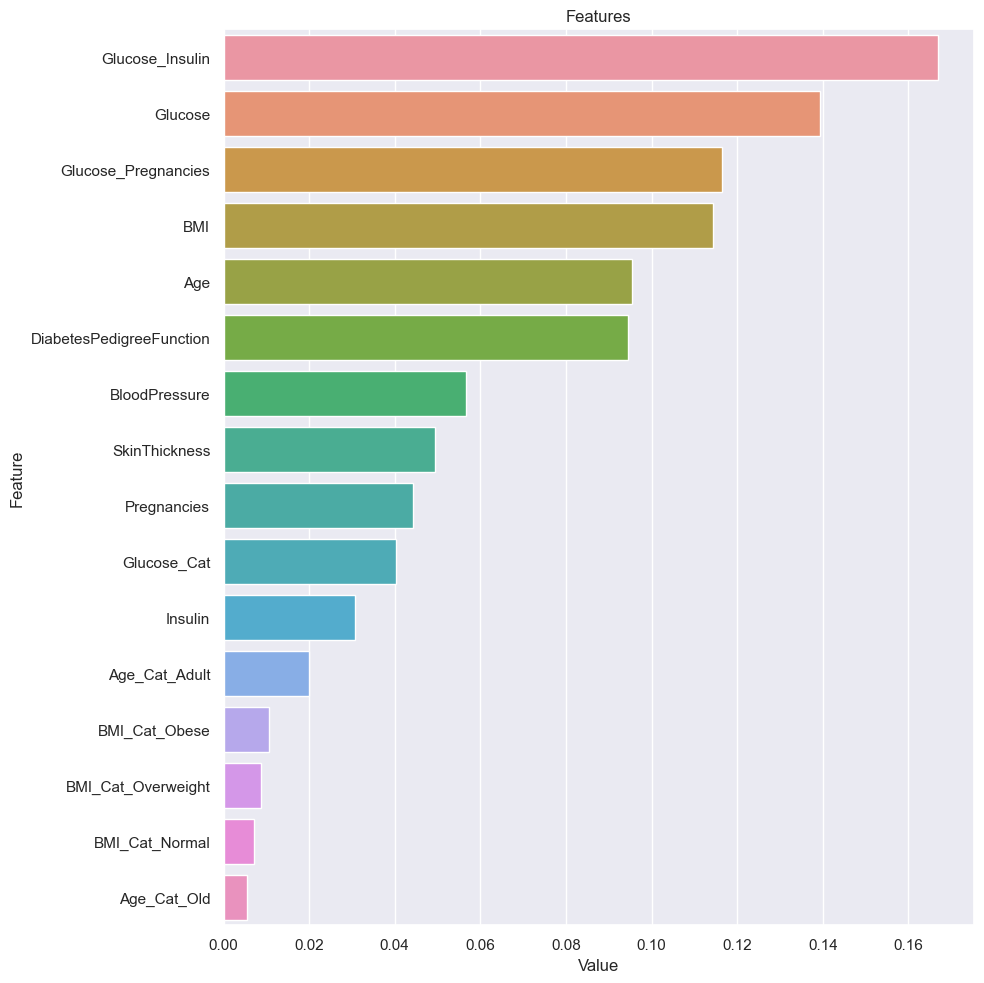

In [362]:
plot_importance(rf_model, X)